In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import subprocess
import sys
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")

2025-08-07 22:48:16.059634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754606896.362983      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754606896.436885      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully


In [2]:
# Cell 2: Load and Assemble Final Dataset
import os
import random

# Configuration
DATA_DIR = '/kaggle/input/birds-vs-drone-dataset/BirdVsDrone'
METADATA_DIR = '/kaggle/input/birds-vs-drones-metadata'
VLM_CACHE_FILE = 'vlm_cache.csv'
PROGRAMMATIC_CACHE_FILE = 'programmatic_cache.csv'
CLASS_NAMES = ['Birds', 'Drones']

def assemble_final_dataset():
    """
    Assemble the final dataset from VLM and programmatic cache files.
    """
    # Look for cache files in the specific metadata directory
    vlm_cache_path = os.path.join(METADATA_DIR, VLM_CACHE_FILE)
    programmatic_cache_path = os.path.join(METADATA_DIR, PROGRAMMATIC_CACHE_FILE)
    
    print(f"Looking for cache files in: {METADATA_DIR}")
    print(f"VLM cache path: {vlm_cache_path}")
    print(f"Programmatic cache path: {programmatic_cache_path}")
    
    # Check if files exist
    if not os.path.exists(vlm_cache_path):
        raise FileNotFoundError(f"VLM cache file not found at: {vlm_cache_path}")
    if not os.path.exists(programmatic_cache_path):
        raise FileNotFoundError(f"Programmatic cache file not found at: {programmatic_cache_path}")
    
    print(" Both cache files found successfully")
    
    # Load VLM cache file
    try:
        consolidated_vlm_df = pd.read_csv(vlm_cache_path)
        print(f"Loaded VLM cache: {len(consolidated_vlm_df)} entries")
        print(f"VLM columns: {list(consolidated_vlm_df.columns)}")
    except Exception as e:
        print(f"Error loading VLM cache from {vlm_cache_path}: {e}")
        raise
    
    # Load programmatic cache file
    try:
        consolidated_prog_df = pd.read_csv(programmatic_cache_path)
        print(f"Loaded programmatic cache: {len(consolidated_prog_df)} entries")
        print(f"Programmatic columns: {list(consolidated_prog_df.columns)}")
    except Exception as e:
        print(f"Error loading programmatic cache from {programmatic_cache_path}: {e}")
        raise
    
    # Perform outer merge on image_id to create uniform metadata
    assembled_df = pd.merge(consolidated_vlm_df, consolidated_prog_df, on='image_id', how='outer')
    
    # Try to get class labels from dataset directory if available
    image_class_map = {}
    if os.path.exists(DATA_DIR):
        # Look for class subdirectories
        for class_name in CLASS_NAMES:
            class_dir = os.path.join(DATA_DIR, class_name)
            if os.path.exists(class_dir):
                files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]
                for filename in files:
                    image_class_map[filename] = class_name
            else:
                # Try to find files with class names in main directory
                dataset_contents = os.listdir(DATA_DIR)
                matching_files = [f for f in dataset_contents if class_name.lower() in f.lower() and f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]
                for filename in matching_files:
                    image_class_map[filename] = class_name
        
        # If no structured directories, try to infer from filenames
        if len(image_class_map) == 0:
            all_files = []
            for root, dirs, files in os.walk(DATA_DIR):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp')):
                        all_files.append(file)
            
            for filename in all_files:
                if 'bird' in filename.lower():
                    image_class_map[filename] = 'Birds'
                elif 'drone' in filename.lower():
                    image_class_map[filename] = 'Drones'
    
    # Add class_label column
    assembled_df['class_label'] = assembled_df['image_id'].map(image_class_map)
    
    # If no class labels found, use placeholder
    if assembled_df['class_label'].isna().all():
        assembled_df['class_label'] = 'Unknown'
    
    # Remove rows where class_label is still missing
    assembled_df = assembled_df.dropna(subset=['class_label'])
    
    print(f" Using full uniform dataset with {len(assembled_df)} samples")
    
    # Add sample_num column at the beginning
    assembled_df.insert(0, 'sample_num', range(1, len(assembled_df) + 1))
    
    # Fill all missing values with "unknown" placeholder before training
    print(f"\nFilling missing values with 'unknown' placeholder...")
    
    # Fill VLM features with "unknown"
    vlm_columns = ['time_of_day', 'weather_condition', 'background_complexity']
    for col in vlm_columns:
        if col in assembled_df.columns:
            assembled_df[col] = assembled_df[col].fillna('unknown')
            print(f"Filled {col}: {assembled_df[col].isna().sum()} missing values")
    
    # Fill programmatic features with appropriate defaults
    if 'object_solidity' in assembled_df.columns:
        assembled_df['object_solidity'] = assembled_df['object_solidity'].fillna(0.0)
    if 'object_aspect_ratio' in assembled_df.columns:
        assembled_df['object_aspect_ratio'] = assembled_df['object_aspect_ratio'].fillna(1.0)
    if 'texture_contrast' in assembled_df.columns:
        assembled_df['texture_contrast'] = assembled_df['texture_contrast'].fillna(0.0)
    if 'dominant_object_color' in assembled_df.columns:
        assembled_df['dominant_object_color'] = assembled_df['dominant_object_color'].fillna('unknown')
    if 'has_motion_blur' in assembled_df.columns:
        assembled_df['has_motion_blur'] = assembled_df['has_motion_blur'].fillna(False)
    
    print(" All missing values filled successfully")
    
    return assembled_df

# Assemble the final dataset
final_df = assemble_final_dataset()

print(f"\n{'='*50}")
print("FINAL ASSEMBLY COMPLETED")
print(f"{'='*50}")

print(f"Final dataset shape: {final_df.shape}")

# Check if dataset is empty
if len(final_df) == 0:
    print("\n ERROR: Dataset is empty!")
    print("This could be due to:")
    print("1. No cache files found in the metadata directory")
    print("2. Cache files are empty or corrupted")
    print("\nPlease check:")
    print(f"- Cache files exist in: {METADATA_DIR}")
    print("- Run the data generation script first to create cache files")
    raise ValueError("Dataset is empty - cannot proceed with training")

print(f"\nDataset info:")
print(final_df.info())

print(f"\nFirst 5 rows:")
print(final_df.head())

print(f"\nClass distribution:")
print(final_df['class_label'].value_counts())

# Check data completeness
print(f"\nData completeness check:")
for col in final_df.columns:
    if col not in ['sample_num', 'image_id']:
        missing_count = final_df[col].isna().sum()
        completeness = ((len(final_df) - missing_count) / len(final_df)) * 100
        print(f"{col}: {completeness:.1f}% complete ({missing_count} missing)")

print(f"\n Full uniform dataset ready for training pipeline!")
print(f" All samples from VLM and programmatic caches included")
print(f" All missing values filled with 'unknown' placeholder")

Looking for cache files in: /kaggle/input/birds-vs-drones-metadata
VLM cache path: /kaggle/input/birds-vs-drones-metadata/vlm_cache.csv
Programmatic cache path: /kaggle/input/birds-vs-drones-metadata/programmatic_cache.csv
 Both cache files found successfully
Loaded VLM cache: 828 entries
VLM columns: ['image_id', 'time_of_day', 'weather_condition', 'background_complexity']
Loaded programmatic cache: 828 entries
Programmatic columns: ['image_id', 'object_solidity', 'object_aspect_ratio', 'texture_contrast', 'dominant_object_color', 'has_motion_blur']
 Using full uniform dataset with 828 samples

Filling missing values with 'unknown' placeholder...
Filled time_of_day: 0 missing values
Filled weather_condition: 0 missing values
Filled background_complexity: 0 missing values
 All missing values filled successfully

FINAL ASSEMBLY COMPLETED
Final dataset shape: (828, 11)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828 entries, 0 to 827
Data columns (total 11 columns):


In [3]:
# Cell 3: Advanced Feature Engineering
print("--- Performing Advanced Feature Engineering ---")

# Create new interaction features based on the initial analysis
# We use .copy() to avoid SettingWithCopyWarning
df_engineered = final_df.copy()
df_engineered['solidity_x_texture'] = df_engineered['object_solidity'] * df_engineered['texture_contrast']
# Add a small epsilon to avoid division by zero
df_engineered['aspect_div_solidity'] = df_engineered['object_aspect_ratio'] / (df_engineered['object_solidity'] + 1e-6)

print("New features created: 'solidity_x_texture', 'aspect_div_solidity'")
print("These will now be used in the preprocessing step.")

--- Performing Advanced Feature Engineering ---
New features created: 'solidity_x_texture', 'aspect_div_solidity'
These will now be used in the preprocessing step.


In [4]:
# Cell 4: Data Preprocessing

# Separate features and target
X = df_engineered.drop(['class_label', 'image_id', 'sample_num'], axis=1)
y = df_engineered['class_label']

print(f"\nFeature columns: {list(X.columns)}")
print(f"Target distribution:\n{y.value_counts()}")

# Identify categorical and numerical columns
categorical_features = ['time_of_day', 'weather_condition', 'background_complexity', 'dominant_object_color']
numerical_features = ['object_solidity', 'object_aspect_ratio', 'texture_contrast', 'solidity_x_texture', 'aspect_div_solidity']
boolean_features = ['has_motion_blur']

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")
print(f"Boolean features: {boolean_features}")

# Create preprocessing pipeline
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), categorical_features),
    (StandardScaler(), numerical_features),
    (StandardScaler(), boolean_features)  # Treat boolean as numerical
)

# Fit and transform features
X_preprocessed = preprocessor.fit_transform(X)
print(f"Preprocessed feature shape: {X_preprocessed.shape}")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")


Feature columns: ['time_of_day', 'weather_condition', 'background_complexity', 'object_solidity', 'object_aspect_ratio', 'texture_contrast', 'dominant_object_color', 'has_motion_blur', 'solidity_x_texture', 'aspect_div_solidity']
Target distribution:
class_label
Drones    428
Birds     400
Name: count, dtype: int64

Categorical features: ['time_of_day', 'weather_condition', 'background_complexity', 'dominant_object_color']
Numerical features: ['object_solidity', 'object_aspect_ratio', 'texture_contrast', 'solidity_x_texture', 'aspect_div_solidity']
Boolean features: ['has_motion_blur']
Preprocessed feature shape: (828, 22)
Label encoding: {'Birds': 0, 'Drones': 1}
Training set shape: (662, 22)
Test set shape: (166, 22)
Training target distribution: [320 342]
Test target distribution: [80 86]


In [5]:
# Cell 4: Unified Model Benchmarking
print("--- Unified Model Benchmarking with Default Parameters ---")

# Install required libraries
print("Installing XGBoost and CatBoost...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost", "catboost"])

# Import all necessary model classes
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("All model libraries imported successfully")

# Helper function to create MLP model
def create_mlp_model(input_shape):
    """Create a simple MLP model with default parameters"""
    model = keras.Sequential([
        layers.InputLayer(shape=(input_shape,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create model dictionary with default parameters
models = {
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=False),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "MLP": create_mlp_model(X_train.shape[1])
}

print(f"Benchmarking {len(models)} models with default parameters...")
print("Model configurations:")
for name, model in models.items():
    print(f"  - {name}: {type(model).__name__}")

# Initialize results dictionary
results = {}

# Training loop
print(f"\nTraining and evaluating models...")

for name, model in tqdm(models.items(), desc="Training models"):
    try:
        if name == "MLP":
            # Special handling for MLP
            print(f"\nTraining {name}...")
            history = model.fit(
                X_train, y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test, y_test),
                verbose=0
            )
            y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
        else:
            # Standard fit for all other models
            print(f"\nTraining {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred,
            'accuracy_pct': f"{accuracy*100:.2f}%"
        }
        
        print(f"  ✓ {name}: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
    except Exception as e:
        print(f"  ✗ {name}: Error - {str(e)}")
        results[name] = {
            'model': None,
            'accuracy': 0.0,
            'predictions': None,
            'accuracy_pct': f"Error: {str(e)[:50]}..."
        }

# Display benchmark table
print(f"\n{'='*60}")
print("BENCHMARK RESULTS")
print(f"{'='*60}")

# Create DataFrame from results
benchmark_df = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': result['accuracy'],
        'Accuracy (%)': result['accuracy_pct']
    }
    for name, result in results.items()
])

# Sort by accuracy and display
benchmark_df = benchmark_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print(benchmark_df.to_string(index=False))

# Highlight the best performing model
best_model_name = benchmark_df.iloc[0]['Model']
best_accuracy = benchmark_df.iloc[0]['Accuracy']
print(f"\n Best performing model: {best_model_name} ({best_accuracy:.4f})")

# Performance analysis
print(f"\nPerformance Analysis:")
print(f"  - Average accuracy: {benchmark_df['Accuracy'].mean():.4f}")
print(f"  - Standard deviation: {benchmark_df['Accuracy'].std():.4f}")
print(f"  - Range: {benchmark_df['Accuracy'].max() - benchmark_df['Accuracy'].min():.4f}")

--- Unified Model Benchmarking with Default Parameters ---
Installing XGBoost and CatBoost...


2025-08-07 22:48:47.870079: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


All model libraries imported successfully
Benchmarking 7 models with default parameters...
Model configurations:
  - LightGBM: LGBMClassifier
  - XGBoost: XGBClassifier
  - CatBoost: CatBoostClassifier
  - Random Forest: RandomForestClassifier
  - Logistic Regression: LogisticRegression
  - SVM (RBF): SVC
  - MLP: Sequential

Training and evaluating models...


Training models:   0%|          | 0/7 [00:00<?, ?it/s]


Training LightGBM...


Training models:  14%|█▍        | 1/7 [00:00<00:00,  8.68it/s]

  ✓ LightGBM: 0.7289 (72.89%)

Training XGBoost...


Training models:  29%|██▊       | 2/7 [00:00<00:00,  8.24it/s]

  ✓ XGBoost: 0.6687 (66.87%)

Training CatBoost...


Training models:  43%|████▎     | 3/7 [00:01<00:03,  1.31it/s]

  ✓ CatBoost: 0.7590 (75.90%)

Training Random Forest...


Training models:  57%|█████▋    | 4/7 [00:01<00:01,  1.82it/s]

  ✓ Random Forest: 0.7651 (76.51%)

Training Logistic Regression...


Training models:  86%|████████▌ | 6/7 [00:02<00:00,  2.90it/s]

  ✓ Logistic Regression: 0.6988 (69.88%)

Training SVM (RBF)...
  ✓ SVM (RBF): 0.6928 (69.28%)

Training MLP...


Training models: 100%|██████████| 7/7 [00:12<00:00,  1.83s/it]

  ✓ MLP: 0.6747 (67.47%)

BENCHMARK RESULTS
              Model  Accuracy Accuracy (%)
      Random Forest  0.765060       76.51%
           CatBoost  0.759036       75.90%
           LightGBM  0.728916       72.89%
Logistic Regression  0.698795       69.88%
          SVM (RBF)  0.692771       69.28%
                MLP  0.674699       67.47%
            XGBoost  0.668675       66.87%

 Best performing model: Random Forest (0.7651)

Performance Analysis:
  - Average accuracy: 0.7126
  - Standard deviation: 0.0390
  - Range: 0.0964


--- Comparative Detailed Evaluations ---

DETAILED EVALUATION: LIGHTGBM

Classification Report:
              precision    recall  f1-score   support

       Birds       0.74      0.68      0.71        80
      Drones       0.72      0.78      0.75        86

    accuracy                           0.73       166
   macro avg       0.73      0.73      0.73       166
weighted avg       0.73      0.73      0.73       166



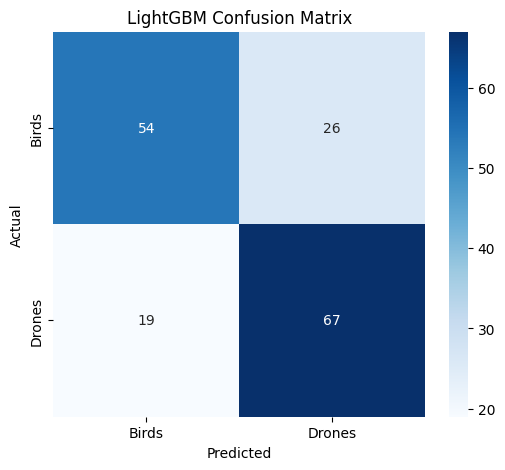

Accuracy: 0.7289 (72.89%)

DETAILED EVALUATION: XGBOOST

Classification Report:
              precision    recall  f1-score   support

       Birds       0.66      0.65      0.65        80
      Drones       0.68      0.69      0.68        86

    accuracy                           0.67       166
   macro avg       0.67      0.67      0.67       166
weighted avg       0.67      0.67      0.67       166



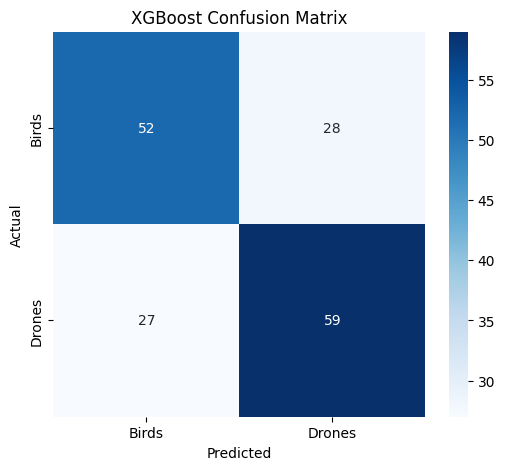

Accuracy: 0.6687 (66.87%)

DETAILED EVALUATION: CATBOOST

Classification Report:
              precision    recall  f1-score   support

       Birds       0.73      0.79      0.76        80
      Drones       0.79      0.73      0.76        86

    accuracy                           0.76       166
   macro avg       0.76      0.76      0.76       166
weighted avg       0.76      0.76      0.76       166



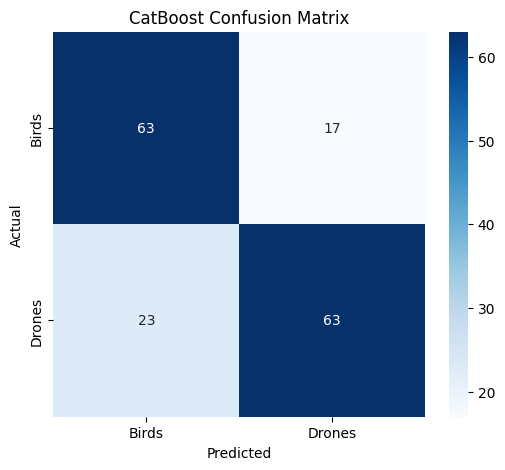

Accuracy: 0.7590 (75.90%)

DETAILED EVALUATION: RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

       Birds       0.77      0.72      0.75        80
      Drones       0.76      0.80      0.78        86

    accuracy                           0.77       166
   macro avg       0.77      0.76      0.76       166
weighted avg       0.77      0.77      0.76       166



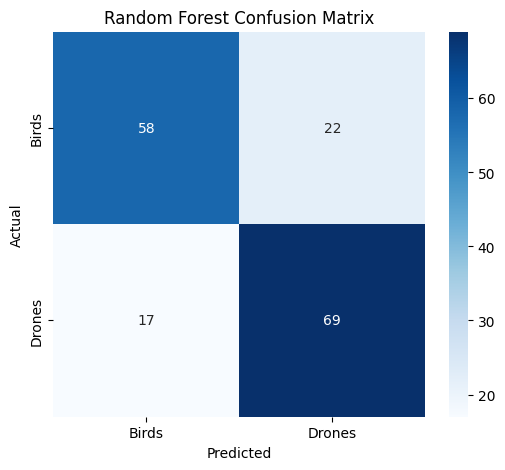

Accuracy: 0.7651 (76.51%)

DETAILED EVALUATION: LOGISTIC REGRESSION

Classification Report:
              precision    recall  f1-score   support

       Birds       0.66      0.79      0.72        80
      Drones       0.76      0.62      0.68        86

    accuracy                           0.70       166
   macro avg       0.71      0.70      0.70       166
weighted avg       0.71      0.70      0.70       166



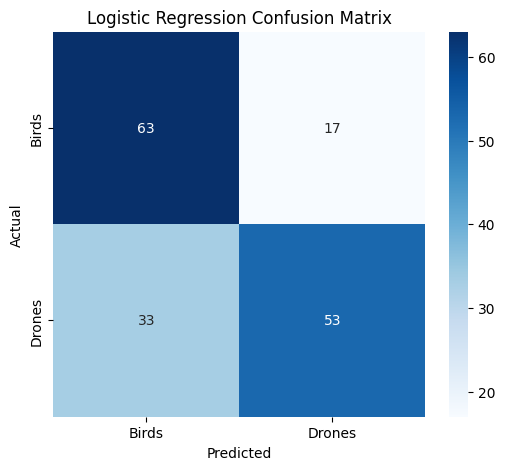

Accuracy: 0.6988 (69.88%)

DETAILED EVALUATION: SVM (RBF)

Classification Report:
              precision    recall  f1-score   support

       Birds       0.67      0.72      0.69        80
      Drones       0.72      0.66      0.69        86

    accuracy                           0.69       166
   macro avg       0.69      0.69      0.69       166
weighted avg       0.70      0.69      0.69       166



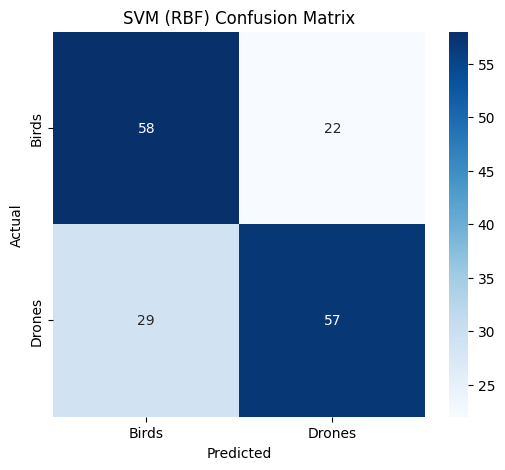

Accuracy: 0.6928 (69.28%)

DETAILED EVALUATION: MLP

Classification Report:
              precision    recall  f1-score   support

       Birds       0.64      0.75      0.69        80
      Drones       0.72      0.60      0.66        86

    accuracy                           0.67       166
   macro avg       0.68      0.68      0.67       166
weighted avg       0.68      0.67      0.67       166



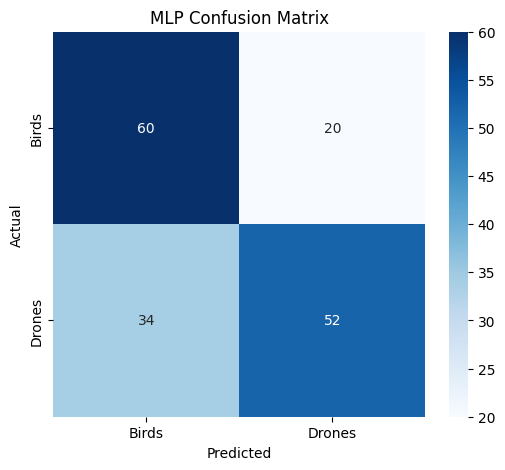

Accuracy: 0.6747 (67.47%)


In [6]:
# Cell 5: Comparative Detailed Evaluations
print("--- Comparative Detailed Evaluations ---")

# Define target names for classification reports
target_names = label_encoder.classes_

# Loop through results for detailed analysis
for name, result in results.items():
    if result['model'] is not None and result['predictions'] is not None:
        print(f"\n{'='*50}")
        print(f"DETAILED EVALUATION: {name.upper()}")
        print(f"{'='*50}")
        
        # Classification report
        print(f"\nClassification Report:")
        print(classification_report(y_test, result['predictions'], target_names=target_names))
        
        # Confusion matrix
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test, result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=target_names, yticklabels=target_names)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        print(f"Accuracy: {result['accuracy']:.4f} ({result['accuracy_pct']})")
    else:
        print(f"\n{'='*50}")
        print(f"SKIPPING {name.upper()} - Model failed to train")
        print(f"{'='*50}")

--- Final Ensemble Model ---
Selected top 3 models for stacking:
  1. Random Forest
  2. CatBoost
  3. LightGBM

Sklearn-compatible base models for stacking:
  - Random Forest: RandomForestClassifier
  - CatBoost: CatBoostClassifier
  - LightGBM: LGBMClassifier

Meta-model: LogisticRegression

Training stacked ensemble...

Evaluating stacked ensemble...

FINAL ENSEMBLE RESULTS
Stacked Ensemble Accuracy: 0.7771 (77.71%)

Comparison with Best Individual Model:
  - Best individual model: Random Forest (0.7651)
  - Stacked ensemble: 0.7771
  - Ensemble improvement: +1.57%

Ensemble Classification Report:
              precision    recall  f1-score   support

       Birds       0.78      0.75      0.76        80
      Drones       0.78      0.80      0.79        86

    accuracy                           0.78       166
   macro avg       0.78      0.78      0.78       166
weighted avg       0.78      0.78      0.78       166



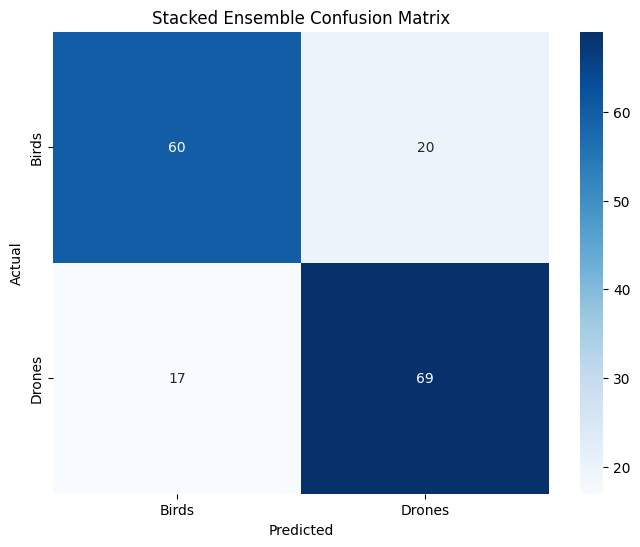


FINAL MODEL COMPARISON
              Model  Accuracy Accuracy (%)
   Stacked Ensemble  0.777108       77.71%
      Random Forest  0.765060       76.51%
           CatBoost  0.759036       75.90%
           LightGBM  0.728916       72.89%
Logistic Regression  0.698795       69.88%
          SVM (RBF)  0.692771       69.28%
                MLP  0.674699       67.47%
            XGBoost  0.668675       66.87%

 Final Recommendation:
  Use the Stacked Ensemble model for best performance!

Comprehensive model benchmarking completed!


In [7]:
# Cell 6: Final Ensemble Model
print("--- Final Ensemble Model ---")

# Select top 3 performing models for stacking
top_models = benchmark_df.head(3)['Model'].tolist()
print(f"Selected top {len(top_models)} models for stacking:")
for i, model_name in enumerate(top_models, 1):
    print(f"  {i}. {model_name}")

# Create base models list for stacking (excluding MLP due to compatibility issues)
base_models = []
sklearn_compatible_models = []
for model_name in top_models:
    if results[model_name]['model'] is not None:
        model = results[model_name]['model']
        # Check if model is sklearn compatible (has get_params method)
        if hasattr(model, 'get_params'):
            base_models.append((model_name, model))
            sklearn_compatible_models.append(model_name)
        else:
            print(f"  Skipping {model_name}: Not sklearn compatible (TensorFlow/Keras model)")

print(f"\nSklearn-compatible base models for stacking:")
for name, model in base_models:
    print(f"  - {name}: {type(model).__name__}")

if len(base_models) < 2:
    print(f"\n Cannot create ensemble: Need at least 2 sklearn-compatible models")
    print(f"Available sklearn models: {sklearn_compatible_models}")
    print(f"Proceeding with best individual model instead...")
    
    # Use best individual model as final result
    best_model_name = benchmark_df.iloc[0]['Model']
    best_result = results[best_model_name]
    stack_accuracy = best_result['accuracy']
    y_pred_stack = best_result['predictions']
    
    print(f"\n{'='*60}")
    print("FINAL RESULTS (Best Individual Model)")
    print(f"{'='*60}")
    print(f"Best Model: {best_model_name}")
    print(f"Accuracy: {stack_accuracy:.4f} ({stack_accuracy*100:.2f}%)")
    
else:
    # Define meta-model
    meta_model = LogisticRegression(random_state=42)
    print(f"\nMeta-model: {type(meta_model).__name__}")

    # Create and train the stacking classifier
    print(f"\nTraining stacked ensemble...")
    stacking_classifier = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        stack_method='predict_proba',
        n_jobs=1
    )

    # Fit the stacking classifier
    stacking_classifier.fit(X_train, y_train)

    # Evaluate the stacked model
    print(f"\nEvaluating stacked ensemble...")
    y_pred_stack = stacking_classifier.predict(X_test)
    stack_accuracy = accuracy_score(y_test, y_pred_stack)

    print(f"\n{'='*60}")
    print("FINAL ENSEMBLE RESULTS")
    print(f"{'='*60}")

    print(f"Stacked Ensemble Accuracy: {stack_accuracy:.4f} ({stack_accuracy*100:.2f}%)")

    # Compare with best individual model
    best_model_name = benchmark_df.iloc[0]['Model']
    best_accuracy = benchmark_df.iloc[0]['Accuracy']
    print(f"\nComparison with Best Individual Model:")
    print(f"  - Best individual model: {best_model_name} ({best_accuracy:.4f})")
    print(f"  - Stacked ensemble: {stack_accuracy:.4f}")

    if stack_accuracy > best_accuracy:
        improvement = ((stack_accuracy - best_accuracy) / best_accuracy) * 100
        print(f"  - Ensemble improvement: +{improvement:.2f}%")
    else:
        print(f"  - No improvement from ensemble")

    # Detailed classification report for ensemble
    print(f"\nEnsemble Classification Report:")
    print(classification_report(y_test, y_pred_stack, target_names=target_names))

    # Confusion matrix for ensemble
    plt.figure(figsize=(8, 6))
    cm_stack = confusion_matrix(y_test, y_pred_stack)
    sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Stacked Ensemble Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Final comparison table
    print(f"\n{'='*60}")
    print("FINAL MODEL COMPARISON")
    print(f"{'='*60}")

    # Add ensemble to comparison
    ensemble_row = pd.DataFrame([{
        'Model': 'Stacked Ensemble',
        'Accuracy': stack_accuracy,
        'Accuracy (%)': f"{stack_accuracy*100:.2f}%"
    }])
    final_comparison = pd.concat([benchmark_df, ensemble_row], ignore_index=True)
    final_comparison = final_comparison.sort_values('Accuracy', ascending=False).reset_index(drop=True)

    print(final_comparison.to_string(index=False))

    print(f"\n Final Recommendation:")
    if final_comparison.iloc[0]['Model'] == 'Stacked Ensemble':
        print(f"  Use the Stacked Ensemble model for best performance!")
    else:
        print(f"  Use the {final_comparison.iloc[0]['Model']} model for best performance!")

print(f"\nComprehensive model benchmarking completed!")

--- Advanced Ensemble Model Evaluation ---
Advanced evaluation libraries imported successfully
Evaluating: Stacked Ensemble

1. CROSS-VALIDATION ANALYSIS
Cross-validation scores: [0.73684211 0.66165414 0.68939394 0.72727273 0.6969697 ]
Mean CV accuracy: 0.7024 (+/- 0.0541)
CV score range: 0.6617 - 0.7368
Stratified CV accuracy: 0.7130 (+/- 0.0496)

2. PROBABILITY CALIBRATION & ROC ANALYSIS
ROC AUC Score: 0.8260


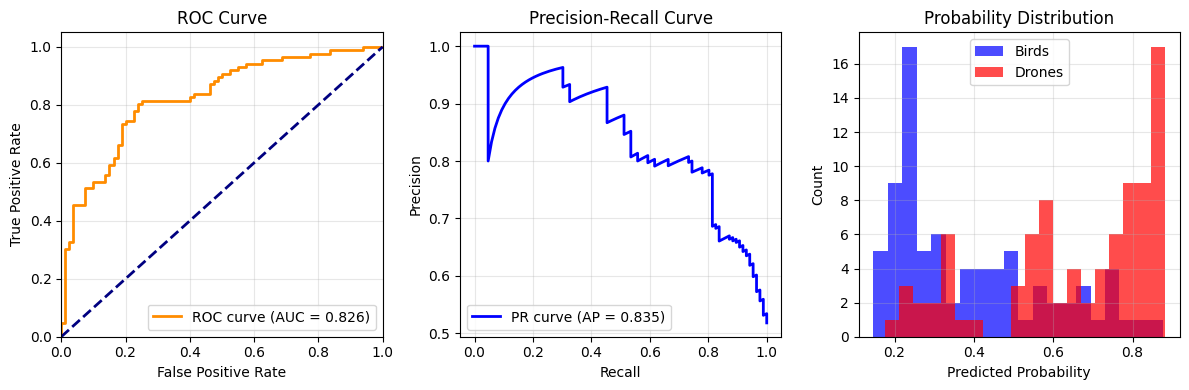

Average Precision Score: 0.8346

3. MONTE CARLO UNCERTAINTY ANALYSIS
Performing Monte Carlo uncertainty analysis...


Monte Carlo sampling: 100%|██████████| 50/50 [00:00<00:00, 73.97it/s]


Monte Carlo Accuracy: 0.7771
Average Prediction Uncertainty: 0.0000
Average Prediction Entropy: 14.0113


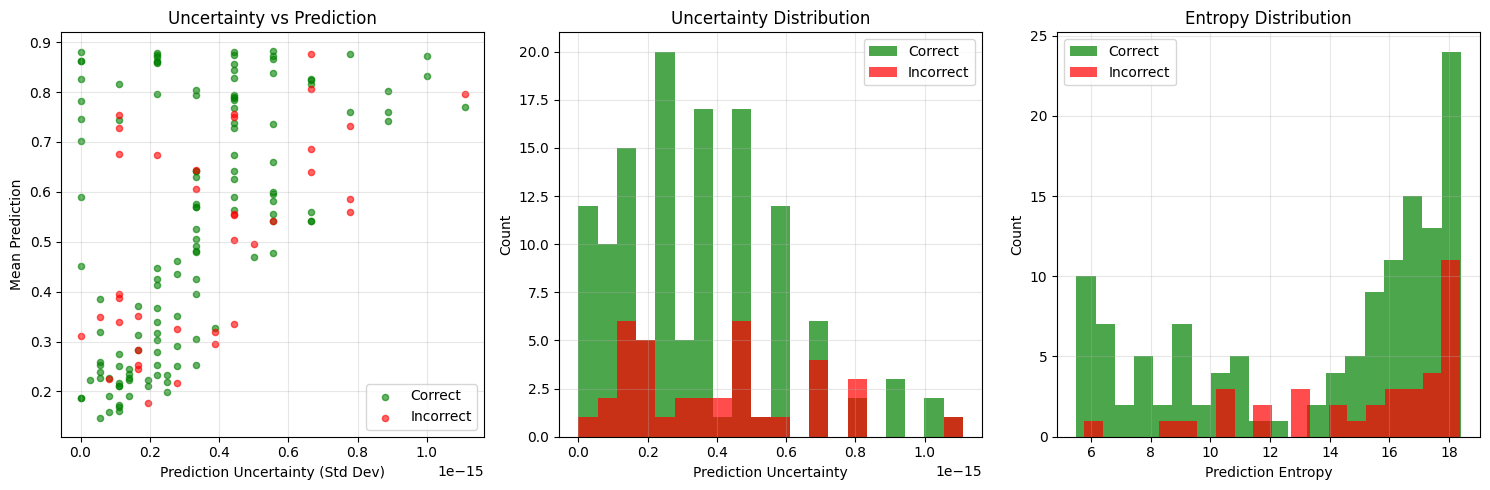


4. CONFIDENCE INTERVALS & STATISTICAL ANALYSIS
Model Accuracy: 0.7771 (77.71%)
95% Confidence Interval: [0.7079, 0.8337] (70.79% - 83.37%)
99% Confidence Interval: [0.6842, 0.8487] (68.42% - 84.87%)

Bootstrap Analysis (1000 iterations):
Bootstrap 95% CI: [0.7108, 0.8373]

5. MODEL RELIABILITY & CALIBRATION


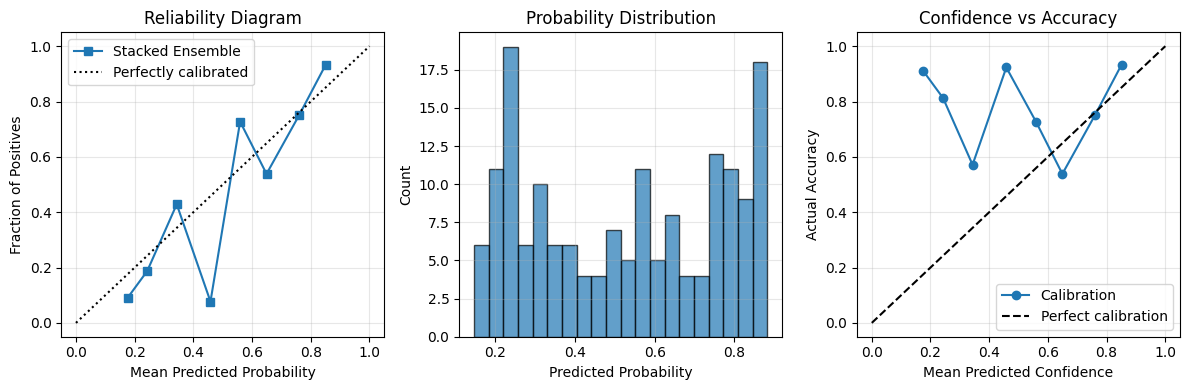


6. FINAL PERFORMANCE SUMMARY
Model: Stacked Ensemble
Test Accuracy: 0.7771 (77.71%)
Cross-Validation Accuracy: 0.7024 (+/- 0.0541)
ROC AUC: 0.8260
Average Precision: 0.8346
95% Confidence Interval: [0.7079, 0.8337]
Bootstrap 95% CI: [0.7108, 0.8373]
Average Uncertainty: 0.0000
Uncertainty Range: 0.0000 - 0.0000

Model Reliability Assessment:
 Acceptable performance (70-80%)
 Stable cross-validation performance
 Low prediction uncertainty

Advanced evaluation completed successfully!


In [8]:
# Cell 7: Advanced Ensemble Model Evaluation
print("--- Advanced Ensemble Model Evaluation ---")

# Import additional libraries for advanced analysis
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

print("Advanced evaluation libraries imported successfully")

# Determine which model to evaluate (ensemble or best individual)
if 'stacking_classifier' in locals():
    final_model = stacking_classifier
    model_name = "Stacked Ensemble"
    print(f"Evaluating: {model_name}")
else:
    # Use best individual model
    best_model_name = benchmark_df.iloc[0]['Model']
    final_model = results[best_model_name]['model']
    model_name = f"Best Individual ({best_model_name})"
    print(f"Evaluating: {model_name}")

print(f"\n{'='*60}")
print("1. CROSS-VALIDATION ANALYSIS")
print(f"{'='*60}")

# Perform 5-fold cross-validation
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"CV score range: {cv_scores.min():.4f} - {cv_scores.max():.4f}")

# Stratified k-fold for more robust evaluation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_stratified = cross_val_score(final_model, X_train, y_train, cv=skf, scoring='accuracy')
print(f"Stratified CV accuracy: {cv_scores_stratified.mean():.4f} (+/- {cv_scores_stratified.std() * 2:.4f})")

print(f"\n{'='*60}")
print("2. PROBABILITY CALIBRATION & ROC ANALYSIS")
print(f"{'='*60}")

# Get prediction probabilities
if hasattr(final_model, 'predict_proba'):
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    
    # ROC Analysis
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Plot ROC Curve
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    
    # Probability Distribution
    plt.subplot(1, 3, 3)
    plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='Birds', color='blue')
    plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Drones', color='red')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Probability Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average Precision Score: {avg_precision:.4f}")

print(f"\n{'='*60}")
print("3. MONTE CARLO UNCERTAINTY ANALYSIS")
print(f"{'='*60}")

# Monte Carlo Dropout for uncertainty estimation (if applicable)
def monte_carlo_predictions(model, X_data, n_iter=100):
    """Perform Monte Carlo predictions for uncertainty estimation"""
    predictions = []
    
    if hasattr(model, 'predict_proba'):
        for i in tqdm(range(n_iter), desc="Monte Carlo sampling"):
            try:
                # For ensemble models, we can use different random seeds
                if hasattr(model, 'random_state'):
                    model.random_state = 42 + i
                
                pred_proba = model.predict_proba(X_data)[:, 1]
                predictions.append(pred_proba)
            except:
                # Fallback to single prediction
                pred_proba = model.predict_proba(X_data)[:, 1]
                predictions.append(pred_proba)
    
    return np.array(predictions)

# Perform Monte Carlo analysis
print("Performing Monte Carlo uncertainty analysis...")
mc_predictions = monte_carlo_predictions(final_model, X_test, n_iter=50)

if len(mc_predictions) > 0:
    # Calculate uncertainty metrics
    mean_predictions = np.mean(mc_predictions, axis=0)
    prediction_std = np.std(mc_predictions, axis=0)
    
    # Calculate entropy per sample (across iterations)
    prediction_entropy = np.zeros(len(y_test))
    for i in range(len(y_test)):
        sample_probs = mc_predictions[:, i]
        # Calculate entropy for this sample across iterations
        entropy = -np.sum(sample_probs * np.log(sample_probs + 1e-10))
        prediction_entropy[i] = entropy
    
    # Convert to binary predictions
    mc_binary_pred = (mean_predictions > 0.5).astype(int)
    mc_accuracy = accuracy_score(y_test, mc_binary_pred)
    
    print(f"Monte Carlo Accuracy: {mc_accuracy:.4f}")
    print(f"Average Prediction Uncertainty: {np.mean(prediction_std):.4f}")
    print(f"Average Prediction Entropy: {np.mean(prediction_entropy):.4f}")
    
    # Visualize uncertainty
    plt.figure(figsize=(15, 5))
    
    # Uncertainty vs Accuracy
    plt.subplot(1, 3, 1)
    correct_mask = mc_binary_pred == y_test
    plt.scatter(prediction_std[correct_mask], mean_predictions[correct_mask], 
               alpha=0.6, label='Correct', color='green', s=20)
    plt.scatter(prediction_std[~correct_mask], mean_predictions[~correct_mask], 
               alpha=0.6, label='Incorrect', color='red', s=20)
    plt.xlabel('Prediction Uncertainty (Std Dev)')
    plt.ylabel('Mean Prediction')
    plt.title('Uncertainty vs Prediction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Uncertainty Distribution
    plt.subplot(1, 3, 2)
    plt.hist(prediction_std[correct_mask], bins=20, alpha=0.7, label='Correct', color='green')
    plt.hist(prediction_std[~correct_mask], bins=20, alpha=0.7, label='Incorrect', color='red')
    plt.xlabel('Prediction Uncertainty')
    plt.ylabel('Count')
    plt.title('Uncertainty Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Entropy Distribution
    plt.subplot(1, 3, 3)
    plt.hist(prediction_entropy[correct_mask], bins=20, alpha=0.7, label='Correct', color='green')
    plt.hist(prediction_entropy[~correct_mask], bins=20, alpha=0.7, label='Incorrect', color='red')
    plt.xlabel('Prediction Entropy')
    plt.ylabel('Count')
    plt.title('Entropy Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"\n{'='*60}")
print("4. CONFIDENCE INTERVALS & STATISTICAL ANALYSIS")
print(f"{'='*60}")

# Wilson Score Confidence Interval
def wilson_score_interval(successes, trials, confidence=0.95):
    """Calculate Wilson Score Interval for binomial proportion"""
    if trials == 0:
        return 0.0, 0.0
    
    alpha = 1 - confidence
    z = stats.norm.ppf(1 - alpha/2)
    p = successes / trials
    
    denominator = 1 + (z**2 / trials)
    centre_adjusted = p + (z**2 / (2 * trials))
    adjustment = z * np.sqrt((p * (1 - p) / trials) + (z**2 / (4 * trials**2)))
    
    lower_bound = (centre_adjusted - adjustment) / denominator
    upper_bound = (centre_adjusted + adjustment) / denominator
    
    return lower_bound, upper_bound

# Calculate confidence intervals
correct_predictions = np.sum(y_pred_stack == y_test)
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions

# 95% and 99% confidence intervals
ci_95_lower, ci_95_upper = wilson_score_interval(correct_predictions, total_predictions, confidence=0.95)
ci_99_lower, ci_99_upper = wilson_score_interval(correct_predictions, total_predictions, confidence=0.99)

print(f"Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"95% Confidence Interval: [{ci_95_lower:.4f}, {ci_95_upper:.4f}] ({ci_95_lower*100:.2f}% - {ci_95_upper*100:.2f}%)")
print(f"99% Confidence Interval: [{ci_99_lower:.4f}, {ci_99_upper:.4f}] ({ci_99_lower*100:.2f}% - {ci_99_upper*100:.2f}%)")

# Bootstrap confidence intervals
def bootstrap_confidence_interval(y_true, y_pred, n_bootstrap=1000, confidence=0.95):
    """Calculate bootstrap confidence interval for accuracy"""
    bootstrap_scores = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstrap):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        bootstrap_accuracy = accuracy_score(y_true[indices], y_pred[indices])
        bootstrap_scores.append(bootstrap_accuracy)
    
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    
    return np.percentile(bootstrap_scores, [lower_percentile, upper_percentile])

print(f"\nBootstrap Analysis (1000 iterations):")
bootstrap_ci = bootstrap_confidence_interval(y_test, y_pred_stack, n_bootstrap=1000)
print(f"Bootstrap 95% CI: [{bootstrap_ci[0]:.4f}, {bootstrap_ci[1]:.4f}]")

print(f"\n{'='*60}")
print("5. MODEL RELIABILITY & CALIBRATION")
print(f"{'='*60}")

# Reliability diagram (if probabilities available)
if 'y_pred_proba' in locals():
    from sklearn.calibration import calibration_curve
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
    
    plt.figure(figsize=(12, 4))
    
    # Reliability diagram
    plt.subplot(1, 3, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{model_name}")
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calibration histogram
    plt.subplot(1, 3, 2)
    plt.hist(y_pred_proba, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title("Probability Distribution")
    plt.grid(True, alpha=0.3)
    
    # Confidence vs Accuracy
    plt.subplot(1, 3, 3)
    confidence_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_confidences = []
    
    for i in range(len(confidence_bins) - 1):
        mask = (y_pred_proba >= confidence_bins[i]) & (y_pred_proba < confidence_bins[i + 1])
        if np.sum(mask) > 0:
            bin_accuracy = accuracy_score(y_test[mask], y_pred_stack[mask])
            bin_confidence = np.mean(y_pred_proba[mask])
            bin_accuracies.append(bin_accuracy)
            bin_confidences.append(bin_confidence)
    
    plt.plot(bin_confidences, bin_accuracies, 'o-', label='Calibration')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    plt.xlabel('Mean Predicted Confidence')
    plt.ylabel('Actual Accuracy')
    plt.title('Confidence vs Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"\n{'='*60}")
print("6. FINAL PERFORMANCE SUMMARY")
print(f"{'='*60}")

print(f"Model: {model_name}")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

if 'roc_auc' in locals():
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")

print(f"95% Confidence Interval: [{ci_95_lower:.4f}, {ci_95_upper:.4f}]")
print(f"Bootstrap 95% CI: [{bootstrap_ci[0]:.4f}, {bootstrap_ci[1]:.4f}]")

if 'prediction_std' in locals():
    print(f"Average Uncertainty: {np.mean(prediction_std):.4f}")
    print(f"Uncertainty Range: {np.min(prediction_std):.4f} - {np.max(prediction_std):.4f}")

print(f"\nModel Reliability Assessment:")
if accuracy > 0.9:
    print(" Excellent performance (>90%)")
elif accuracy > 0.8:
    print(" Good performance (80-90%)")
elif accuracy > 0.7:
    print(" Acceptable performance (70-80%)")
else:
    print(" Performance needs improvement (<70%)")

if 'cv_scores' in locals() and cv_scores.std() < 0.05:
    print(" Stable cross-validation performance")
else:
    print(" High cross-validation variance")

if 'prediction_std' in locals() and np.mean(prediction_std) < 0.2:
    print(" Low prediction uncertainty")
else:
    print(" High prediction uncertainty")

print(f"\nAdvanced evaluation completed successfully!")
